## Importing libraries

In [1]:
# Watching for changes in modules
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    utils,
    optimizers,
    metrics,
)

from scipy.stats import norm
from scripts.utils import display, sample_batch, preprocess

## Preparing Data

### Loading and Initial Exploration of the Dataset

In [2]:
from tensorflow.keras.datasets import cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode="coarse")

In [3]:
# Labels can be found here https://www.cs.toronto.edu/~kriz/cifar.html
coarse_classes = [
    "aquatic mammals", "fish", "flowers", "food containers", "fruit and vegetables",
    "household electrical devices", "household furniture", "insects", "large carnivores",
    "large man-made outdoor things", "large natural outdoor scenes", "large omnivores and herbivores",
    "medium-sized mammals", "non-insect invertebrates", "people", "reptiles",
    "small mammals", "trees", "vehicles 1", "vehicles 2"
]

print("Coarse classes (20):", coarse_classes)

Coarse classes (20): ['aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables', 'household electrical devices', 'household furniture', 'insects', 'large carnivores', 'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores', 'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2']


In [4]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 1) (10000, 1)


### Setting parameters

In [5]:
IMAGE_SIZE = x_train.shape[1]
CHANNELS = x_train.shape[3]
BATCH_SIZE = 100
# BUFFER_SIZE = 1000
# VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 50

### Preprocessing

In [6]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

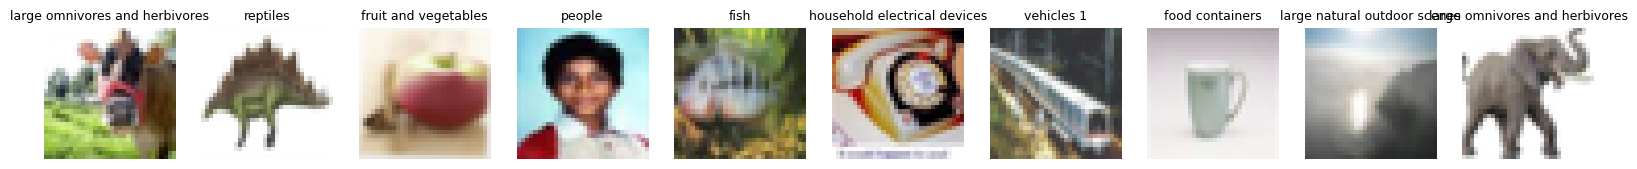

In [7]:
display(x_train, labels=y_train.squeeze(), class_names=coarse_classes, n=10)

# Autoencoder

### Encoder

In [8]:
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output, name="Encoder_functional")
encoder.summary()

Model: "Encoder_functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,346 (380.26 KB)

 Trainable params: 97,346 (380.26 KB)

 Non-trainable params: 0 (0.00 B)

### Decoder

In [9]:
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output, name="Decoder_functional")
decoder.summary()

Model: "Decoder_functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,851 (964.26 KB)

 Trainable params: 246,851 (964.26 KB)

 Non-trainable params: 0 (0.00 B)

### Autoencoder

In [10]:
autoencoder = models.Model(
    encoder_input, decoder(encoder_output),name="Autoencoder_functional"
)
autoencoder.summary()

Model: "Autoencoder_functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_functional (Functional) │ (None, 32, 32, 3)      │       246,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 344,197 (1.31 MB)

 Trainable params: 344,197 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

The next line will be used to see how the latent space evolves during training

In [11]:
autoencoder.encoder = encoder

### Preparing visualization of the Latent Space Evolution

In [12]:
from sklearn.manifold import TSNE
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import os

class EmbeddingLogger(Callback):
    def __init__(self, data, labels=None, log_dir="./logs/embeddings"):
        """
        Parameters:
        - data: Input data to visualize (e.g., x_vis)
        - labels: Optional class labels for coloring (same length as data)
        - log_dir: Directory to save plots
        """
        super().__init__()
        self.data = data
        self.labels = labels
        self.log_dir = log_dir
        os.makedirs(log_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):

        if epoch % 5 != 0:
            return

        embeddings = self.model.encoder(self.data, training=False).numpy()
        tsne = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

        plt.figure(figsize=(6, 4))
        scatter = plt.scatter(
            tsne[:, 0],
            tsne[:, 1],
            c=self.labels if self.labels is not None else "gray",
            cmap="tab10",   # or 'viridis', 'Spectral', etc.
            alpha=0.6,
            s=8
        )
        if self.labels is not None:
            plt.colorbar(scatter, label="Label")
        plt.title(f"t-SNE of embeddings – Epoch {epoch}")
        plt.savefig(f"{self.log_dir}/embedding_epoch_{epoch:03d}.png")
        plt.close()


### Training

First the compilation

In [13]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

Saving useful information in the **checkpoint** directory.

In [14]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/best_model.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

The next line is for the visualization of the latent space evolution

In [15]:
# x_vis = x_train[:1000]
# embedding_logger = EmbeddingLogger(x_vis, log_dir="./logs/embeddings")

In [16]:
x_vis = x_train[:1000]
y_vis = y_train[:1000].squeeze()  # labels must match x_vis in shape

embedding_logger = EmbeddingLogger(x_vis, labels=y_vis, log_dir="./logs/embeddings")


The actual **training**

In [19]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback, embedding_logger],
)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - loss: 0.6179 - val_loss: 0.6185
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - loss: 0.6173 - val_loss: 0.6182
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 0.6167 - val_loss: 0.6183
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - loss: 0.6184 - val_loss: 0.6184
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 0.6167 - val_loss: 0.6182
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - loss: 0.6175 - val_loss: 0.6180
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 0.6182 - val_loss: 0.6180
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 0.6175 - val_loss: 0.6189
Epoch 9/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - loss: 0.6173 - val_loss: 0.6180
Epoch 10/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 0.6174 - val_loss: 0.6180
Epoch 11/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - loss: 0.6172 - val_loss: 0.6182
Epoch 12/50
500/500 ━━━━━━━━━━

### Saving the final models

In [ ]:
autoencoder.save("./models/autoencoder.keras")
encoder.save("./models/encoder.keras")
decoder.save("./models/decoder.keras")

Animation of the latent space evolution

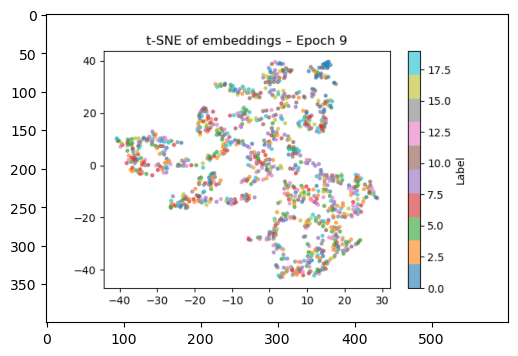

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import glob
from IPython.display import HTML

fig = plt.figure(figsize=(6, 4))

png_files = sorted(glob.glob("./logs/embeddings/embedding_epoch_*.png"))
images = [plt.imshow(Image.open(f), animated=True) for f in png_files]

ani = animation.ArtistAnimation(fig, [[img] for img in images], interval=500, blit=True)
ani.save("assets/embedding_evolution.gif", writer="pillow", fps=1)

# HTML(ani.to_jshtml())  # JS-based animation display
# from IPython.display import Image
# Image(filename="assets/embedding_evolution.gif")
# plt.close(fig)



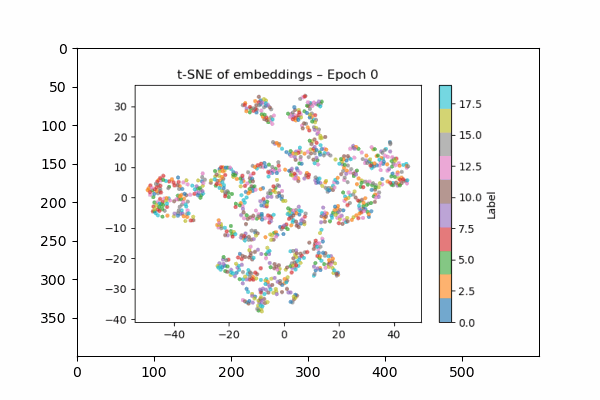

In [ ]:
from IPython.display import Image
Image(filename="assets/embedding_evolution.gif")


# Reconstruction

In [20]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Original images


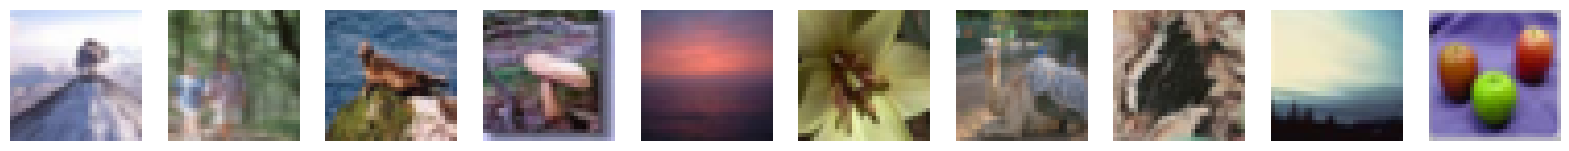

Reconstructions


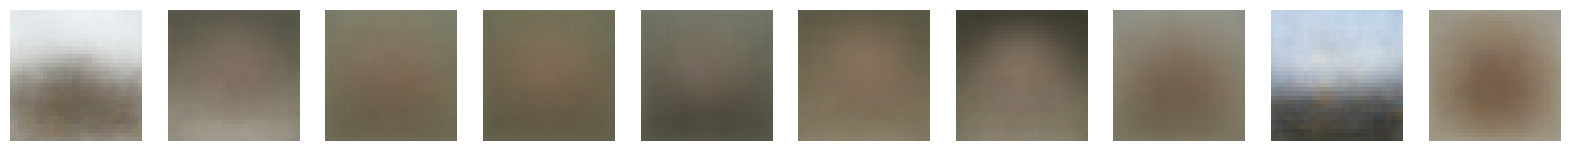

In [21]:
predictions = autoencoder.predict(example_images)

print("Original images")
display(example_images)
print("Reconstructions")
display(predictions)

In [22]:
embeddings = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [23]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [24]:
# Decode the sampled points
reconstructions = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


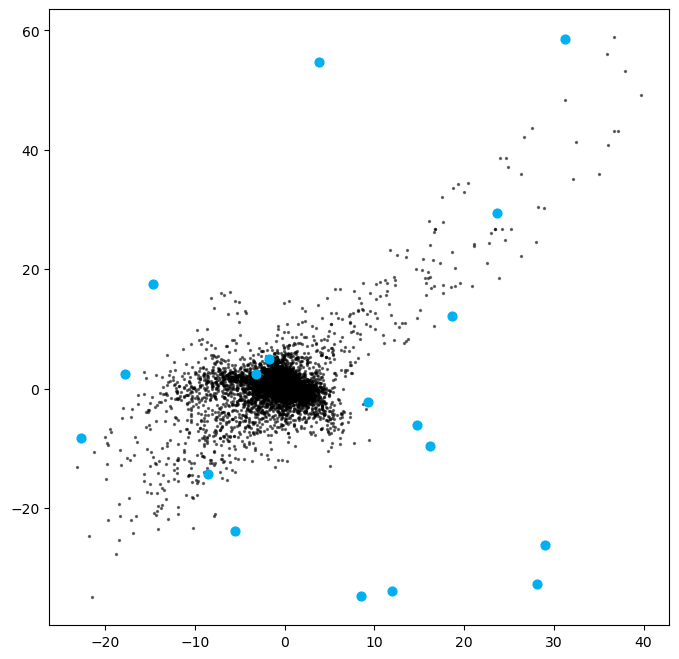

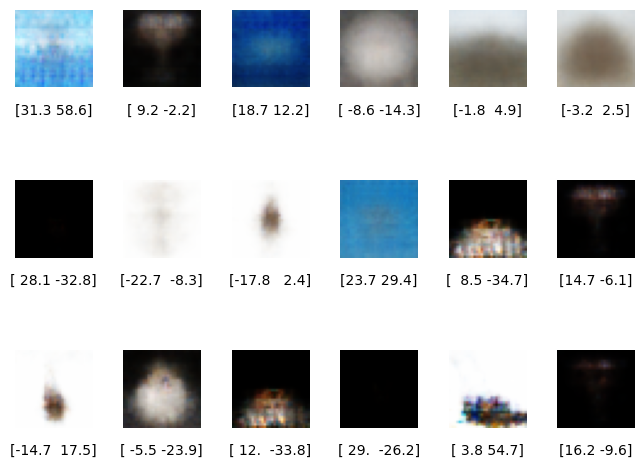

In [25]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


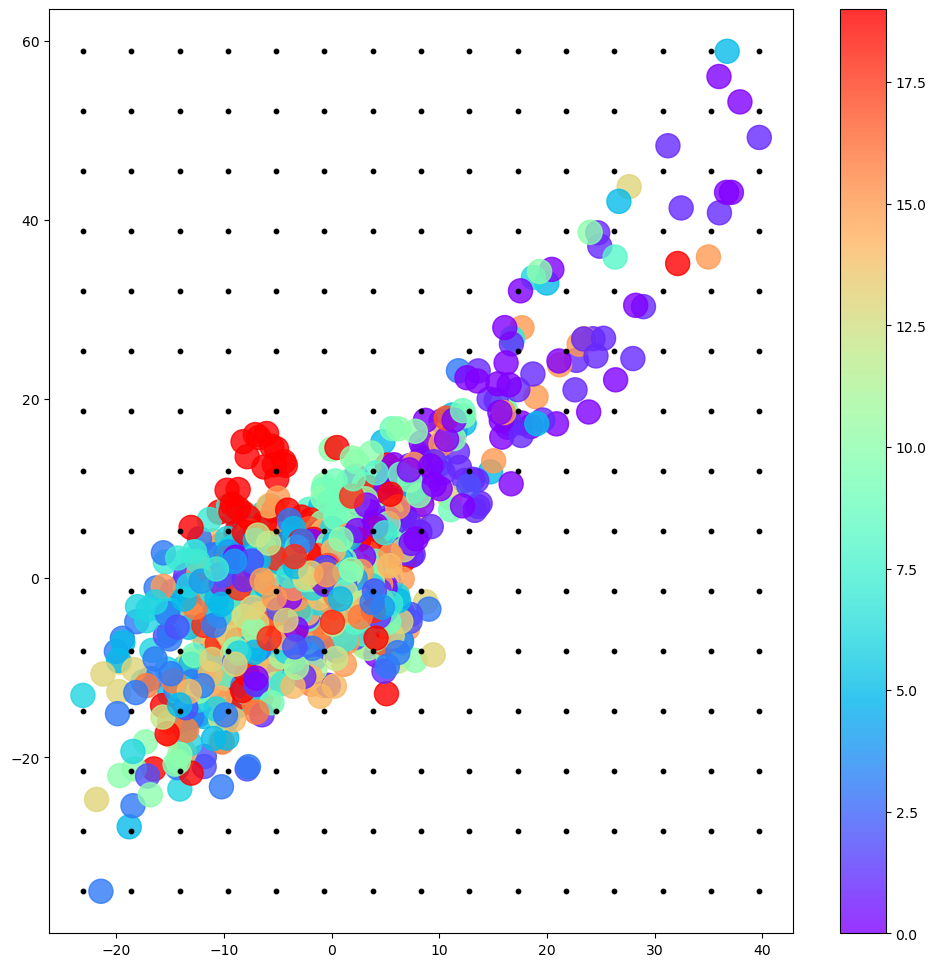

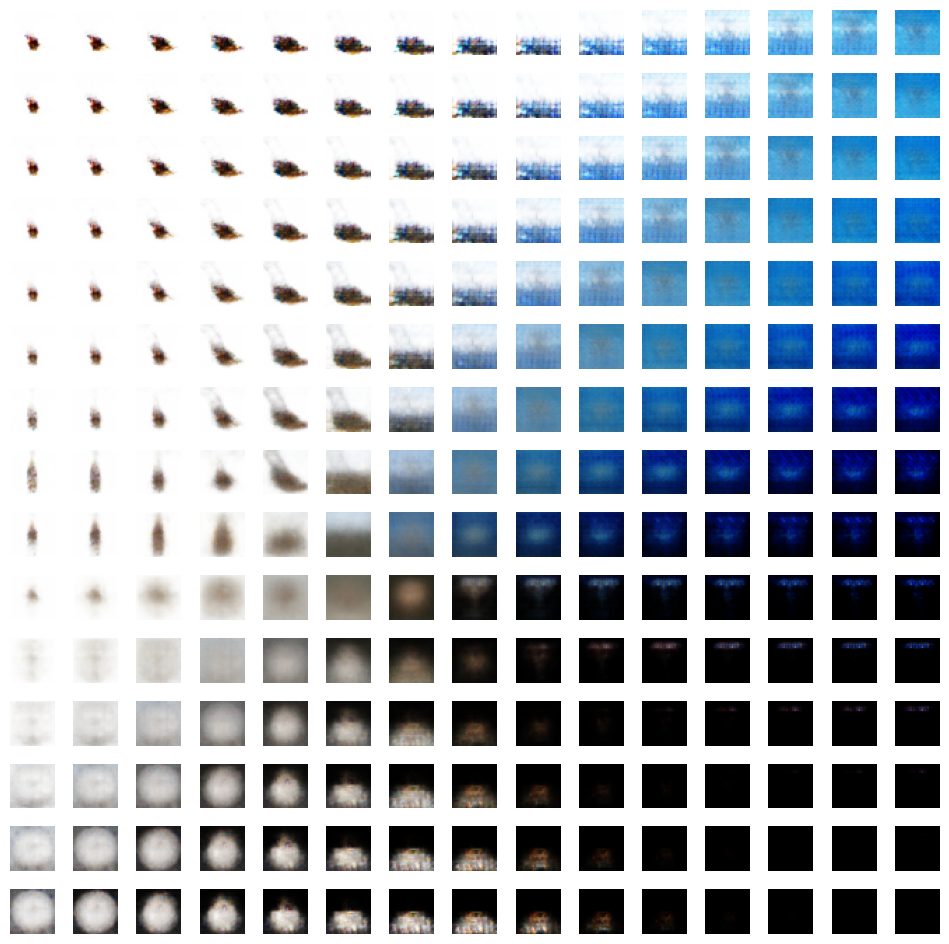

In [26]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

The reconstructions are too blurry, there are many choices to improve this situation:

1. Larger latent space

2. Switch to a Variational Autoencoder (VAE): Regularization to encourage generalization, not just memorization

3. Deeper decoder: Use Conv2DTranspose layers with ReLU, batch norm, etc.

So here we can clearly appreciate the limitations of a simple autoencoder learning complex pattersn.